In [2]:
import numpy as np
from numpy.linalg import inv, pinv, norm, qr
from matplotlib import pyplot as plt

In [3]:
def compute_SMW(n,k,A,B,U,V,lamda,e1,e2,rand_seed=1):
    noise1 = np.random.normal(size=(n,n))
    noise1 *= e1/norm(noise1,ord=2)
    # noise1[-1,-1] = -e1
    # noise1 = V_A@noise1@U_A.T
    noise2 = np.random.normal(size=(k,k))
    noise2 *= e2/norm(noise2,ord=2)

    A_inv = inv(A)
    A_inv_norm = norm(A_inv,ord=2)
    A_til_inv = A_inv + noise1
    Z_inv = inv(np.eye(k)+V.T@A_til_inv@U) + noise2
    B_inv_approx = A_til_inv - A_til_inv@U@Z_inv@V.T@A_til_inv
    B_inv = inv(B) 
    alpha = np.linalg.norm(inv(np.eye(k)+V.T@A_inv@U),ord=2)
    error = norm(B_inv-B_inv_approx,ord=2)
    bound = 2*lamda**2 *e1*A_inv_norm**2*alpha**2
    # B_inv_A_norm = norm(B_inv@A,ord=2)
    # full_bound = e1 + ((A_inv_norm + e1)**2)*lamda*e2+ 2*(A_inv_norm+e1)**2 * lamda**2 * alpha**2 * e1 + (2*A_inv_norm+e1)*lamda*alpha*e1
    full_bound = e1 + e1*lamda*(2*A_inv_norm+e1)*alpha + lamda*(A_inv_norm+e1)**2 *(e2+2*e1*lamda*alpha**2)
    return error,bound,full_bound#,e2*lamda*A_inv_norm**2


In [20]:
small_update = False
n = 1000
k = 20
epsilon = 1e-3 if small_update else 1e-10
num_experiments =100
S_A = np.logspace(2, -2, n)
sigma_max, sigma_min = np.max(S_A), np.min(S_A)
lamda = 2*sigma_min if small_update else 2 * sigma_max
index_list = list(range(int(n / 4), int(n * 3 / 4), 20))

alphas = np.logspace(1,6,len(index_list)) if small_update else np.logspace(1,9,len(index_list))
errors = np.zeros(len(alphas), dtype=float)
bounds = np.zeros(len(alphas), dtype=float)
full_bounds = np.zeros(len(alphas), dtype=float)
# first_terms = np.zeros(len(alphas), dtype=float)
# A = np.diag(S_A)
U_A,_ = qr(np.random.randn(n,n))
V_A,_ = qr(np.random.randn(n,n))
A = U_A @ np.diag(S_A) @ V_A.T
I = np.eye(n)
Q = I[:,-k:]
for i, index in enumerate(index_list):
    alpha = alphas[i]
    error_total = 0.0
    bound_total = 0.0
    full_bound_total = 0.0
    # first_term_total = 0.0
    U = U_A@Q
    S_diag = np.zeros(n)
    S_diag[-k] = lamda
    for j in range(n-k+1,n-1):
        S_diag[j] = abs(1/alpha-1)*S_A[j]*1.001 #(1/alpha-1)*S_A[j] #
    S_diag[-1] = (1/alpha-1)*S_A[-1]
    # s_min, s_max = np.min(S_diag[-k:-1]), np.max(S_diag[-k:-1])
    # S_diag[:n-k] = np.random.uniform(s_min,s_max,n-k) # [  (1/alpha-1)*S_A[j] for j in range(n-k)]# 
    S = np.diag(S_diag)
    V = V_A@S@Q
    B = A + U @ V.T
    assert abs(alpha-norm(inv(np.eye(k)+V.T@inv(A)@U),ord=2))/alpha< 1e-3
    assert abs(lamda-norm(U,ord=2)*norm(V,ord=2))/lamda<1e-3
    for experiment in range(num_experiments):
        err, b, fb = compute_SMW(n, k, A, B, U, V, lamda, epsilon, epsilon)
        error_total += err
        bound_total += b
        full_bound_total += fb
        # first_term_total += ft

    # Store the average values over the experiments
    errors[i] = error_total / num_experiments
    bounds[i] = bound_total / num_experiments
    full_bounds[i] = full_bound_total / num_experiments
    # first_terms[i] = first_term_total / num_experiments




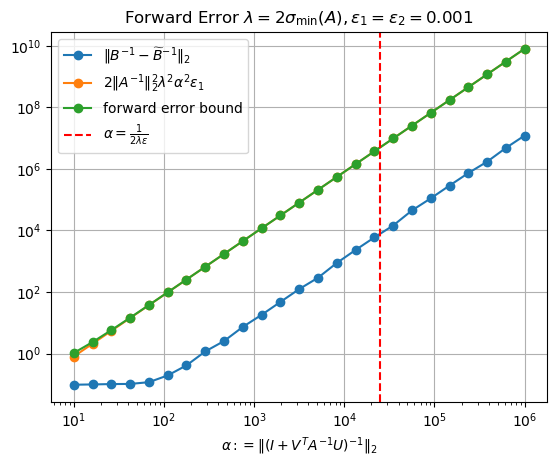

In [ ]:
# Plotting
plt.loglog(alphas, errors, label=r'$\|B^{-1}-\widetilde{B}^{-1}\|_2$',marker='o')
plt.loglog(alphas, bounds, label=r'$ 2 \|  A^{-1 }\|_2^2 \lambda^2 \alpha^2 \epsilon_1$',marker='o')
plt.loglog(alphas, full_bounds, label='forward error bound',marker='o')
# plt.loglog(alphas, first_terms, label=r'$\|  A^{-1 }\|_2^2 \lambda \epsilon_2$')
plt.xlabel(r'$\alpha := \|\left(I + V^T A^{-1} U\right)^{-1}\|_{2}$')
x_value = 1 / (2 * lamda * epsilon)
plt.axvline(x=x_value, color='red', ls='--', label=r'$\alpha = \frac{1}{2 \lambda \epsilon}$')
plt.title("Forward Error "+(r'$\lambda = 2\sigma_{\min}(A), \epsilon_1 = \epsilon_2 = $' if small_update else r'$\lambda = 2\sigma_{\max}(A), \epsilon_1 = \epsilon_2 = $')+str(epsilon))
plt.legend()
plt.grid()
plt.savefig("diagonal_experiments/diagonal_forward_error_small_update.png" if small_update else "diagonal_experiments/diagonal_forward_error_large_update.png")
